# README
- This file is used to check and drop duplicated entries.

In [1]:
import pandas as pd

In [2]:
data_base_dir = "C:/Users/31155/Dropbox/EV-GasDualNetwork/Data/intermediate/yiwei/intermidiate"

data_GS_dir = f"{data_base_dir}/GS_cleaned"
GS_data_set = {}
for year in range(2013, 2026):
    GS_data_set[year] = pd.read_parquet(f"{data_GS_dir}/GS_data_{year}.parquet")
    print(f"GS data for {year} loaded, Length: {len(GS_data_set[year])}")

data_CS_dir = f"{data_base_dir}/CS_cleaned"
CS_data_set = {}
for year in range(2015, 2026):
    CS_data_set[year] = pd.read_parquet(f"{data_CS_dir}/CS_data_{year}.parquet")
    print(f"CS data for {year} loaded, Length: {len(CS_data_set[year])}")


GS data for 2013 loaded, Length: 101591
GS data for 2014 loaded, Length: 104327
GS data for 2015 loaded, Length: 118011
GS data for 2016 loaded, Length: 119393
GS data for 2017 loaded, Length: 118441
GS data for 2018 loaded, Length: 107083
GS data for 2019 loaded, Length: 113338
GS data for 2020 loaded, Length: 119894
GS data for 2021 loaded, Length: 121506
GS data for 2022 loaded, Length: 110988
GS data for 2023 loaded, Length: 118521
GS data for 2024 loaded, Length: 118537
GS data for 2025 loaded, Length: 118315
CS data for 2015 loaded, Length: 1856
CS data for 2016 loaded, Length: 1909
CS data for 2017 loaded, Length: 4252
CS data for 2018 loaded, Length: 33552
CS data for 2019 loaded, Length: 56661
CS data for 2020 loaded, Length: 72863
CS data for 2021 loaded, Length: 93370
CS data for 2022 loaded, Length: 97896
CS data for 2023 loaded, Length: 119790
CS data for 2024 loaded, Length: 184763
CS data for 2025 loaded, Length: 266935


In [3]:
match_columns = ['pname','cityname','adname','address','name']

print("==============GS==============")
for key in GS_data_set.keys():
    data_tmp = GS_data_set[key]
    duplicated_rows = data_tmp[data_tmp.duplicated(subset=match_columns, keep=False)]
    duplicate_count = len(duplicated_rows)
    unique_duplicate_groups = data_tmp.duplicated(subset=match_columns, keep='first').sum()
    
    print(f"Year {key}: Total rows: {len(data_tmp)}, Duplicate percentage: {duplicate_count/len(data_tmp)*100:.2f}%")

print("==============CS==============")
for key in CS_data_set.keys():
    data_tmp = CS_data_set[key]
    duplicated_rows = data_tmp[data_tmp.duplicated(subset=match_columns, keep=False)]
    duplicate_count = len(duplicated_rows)
    unique_duplicate_groups = data_tmp.duplicated(subset=match_columns, keep='first').sum()
    
    print(f"Year {key}: Total rows: {len(data_tmp)}, Duplicate percentage: {duplicate_count/len(data_tmp)*100:.2f}%")

==============GS==============
Year 2013: Total rows: 101591, Duplicate percentage: 31.93%
Year 2014: Total rows: 104327, Duplicate percentage: 10.82%
Year 2015: Total rows: 118011, Duplicate percentage: 2.28%
Year 2016: Total rows: 119393, Duplicate percentage: 2.84%
Year 2017: Total rows: 118441, Duplicate percentage: 1.02%
Year 2018: Total rows: 107083, Duplicate percentage: 1.45%
Year 2019: Total rows: 113338, Duplicate percentage: 1.29%
Year 2020: Total rows: 119894, Duplicate percentage: 0.92%
Year 2021: Total rows: 121506, Duplicate percentage: 0.41%
Year 2022: Total rows: 110988, Duplicate percentage: 0.25%
Year 2023: Total rows: 118521, Duplicate percentage: 0.28%
Year 2024: Total rows: 118537, Duplicate percentage: 0.25%
Year 2025: Total rows: 118315, Duplicate percentage: 0.72%
==============CS==============
Year 2015: Total rows: 1856, Duplicate percentage: 3.23%
Year 2016: Total rows: 1909, Duplicate percentage: 4.40%
Year 2017: Total rows: 4252, Duplicate percentage: 1.72

In [4]:
import sys
sys.path.append("C:/Users/31155/Dropbox/EV-GasDualNetwork/code/yiwei/utils")
from cal_nst_neb_dstn_distribution import calculate_distance_with_xy

In [5]:
calculate_distance_with_xy(100,20,100.01,20.01)

1525.8302668289004

In [6]:
# Compare duplicate rates with and without distance filtering
import matplotlib.pyplot as plt
import numpy as np

def find_duplicates_with_distance(df, match_cols, distance_threshold=50, plot_distribution=False, non_null_cols=None, show_missing = False,max_display_distance=1000):
    """Find duplicates based on columns and distance threshold
    
    Parameters:
    df: DataFrame to analyze
    match_cols: columns to match for duplicates
    distance_threshold: distance threshold in meters
    plot_distribution: whether to plot distance distribution
    non_null_cols: optional list of columns that must not be null for matching
    max_display_distance: maximum distance to display in histogram (default: 1000m)
    """
    # Filter data based on non-null requirements if specified
    if non_null_cols is not None:
        # Start with original dataframe
        filtered_df = df.copy()
        
        # First remove null values
        filtered_df = filtered_df.dropna(subset=non_null_cols)
        
        if show_missing:
            for col in non_null_cols:
                if col in filtered_df.columns:
                    # Filter out empty strings and strings with only whitespace
                    filtered_df = filtered_df[
                        (filtered_df[col].astype(str).str.strip() == '') |
                        (filtered_df[col].astype(str).str.strip() == '[]')
                    ]
        else:
            # Then remove empty strings and whitespace-only strings
            for col in non_null_cols:
                if col in filtered_df.columns:
                    # Filter out empty strings and strings with only whitespace
                    filtered_df = filtered_df[
                        (filtered_df[col].astype(str).str.strip() != '') &
                        (filtered_df[col].astype(str).str.strip() != '[]')
                    ]
        
        print(f"Filtered from {len(df)} to {len(filtered_df)} rows based on non-null/non-empty columns: {non_null_cols}")
    else:
        filtered_df = df
    
    # First find potential duplicates by columns
    potential_duplicates = filtered_df[filtered_df.duplicated(subset=match_cols, keep=False)]
    
    if len(potential_duplicates) == 0:
        return [] if not plot_distribution else ([], [])
    
    # Group by match columns and check distances within each group
    true_duplicates = []
    all_distances = []  # Store all distances between potential duplicates
    
    for _, group in potential_duplicates.groupby(match_cols):
        if len(group) > 1:
            group_indices = group.index.tolist()
            # Check pairwise distances within the group
            for i in range(len(group_indices)):
                for j in range(i+1, len(group_indices)):
                    idx1, idx2 = group_indices[i], group_indices[j]
                    x1, y1 = filtered_df.loc[idx1, 'wgs84_x'], filtered_df.loc[idx1, 'wgs84_y']
                    x2, y2 = filtered_df.loc[idx2, 'wgs84_x'], filtered_df.loc[idx2, 'wgs84_y']

                    # Calculate distance in meters
                    distance = calculate_distance_with_xy(x1, y1, x2, y2)
                    all_distances.append(distance)
                    
                    if idx1 not in true_duplicates:
                        true_duplicates.append(idx1)
                    if idx2 not in true_duplicates:
                        true_duplicates.append(idx2)
    
    # Plot distance distribution if requested
    if plot_distribution and len(all_distances) > 0:
        plt.figure(figsize=(12, 8))
        
        # Filter out invalid values (NaN, inf) and convert to numpy array
        all_distances_array = np.array(all_distances)
        valid_distances = all_distances_array[np.isfinite(all_distances_array)]
        
        if len(valid_distances) == 0:
            print("Warning: No valid distance values found!")
            return true_duplicates, all_distances if plot_distribution else true_duplicates
        
        # Create bins: 99 bins for 0-max_display_distance, plus 1 bin for >max_display_distance
        bins = np.linspace(0, max_display_distance, 100)
        bins = np.append(bins, np.inf)  # Add infinity for the last bin
        
        # Create histogram with custom bins using valid distances only
        n, bin_edges, patches = plt.hist(valid_distances, bins=bins, alpha=0.7, 
                                       color='skyblue', edgecolor='black', density=False)
        
        # Color the last bin (>max_display_distance) differently
        if len(patches) > 99:
            patches[-1].set_color('lightcoral')
            patches[-1].set_alpha(0.8)
        
        # Add threshold line (only if within display range)
        if distance_threshold <= max_display_distance:
            plt.axvline(x=distance_threshold, color='red', linestyle='--', linewidth=2, 
                       label=f'Selected Threshold: {distance_threshold}m')
        
        # Add statistics annotations (only if within display range)
        mean_dist = np.mean(valid_distances)
        median_dist = np.median(valid_distances)
        if mean_dist <= max_display_distance:
            plt.axvline(x=mean_dist, color='green', linestyle=':', linewidth=2, 
                       label=f'Mean Distance: {mean_dist:.1f}m')
        if median_dist <= max_display_distance:
            plt.axvline(x=median_dist, color='orange', linestyle=':', linewidth=2, 
                       label=f'Median Distance: {median_dist:.1f}m')
        
        # Set labels and title
        plt.xlabel('Distance (meters)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'Distance Distribution Between Duplicate Gas Stations (0-{max_display_distance}m + >{max_display_distance}m)', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Set x-axis limits and customize ticks
        plt.xlim(0, max_display_distance)
        x_ticks = np.arange(0, max_display_distance + 1, max(100, max_display_distance // 10))
        x_tick_labels = [str(int(x)) if x < max_display_distance else f'>{max_display_distance}' for x in x_ticks]
        plt.xticks(x_ticks, x_tick_labels)
        
        # Add text box with statistics using valid distances
        pairs_over_max = sum(1 for d in valid_distances if d > max_display_distance)
        pairs_within_max = len(valid_distances) - pairs_over_max
        invalid_pairs = len(all_distances) - len(valid_distances)
        
        stats_text = f'Total Valid Pairs: {len(valid_distances)}\n'
        if invalid_pairs > 0:
            stats_text += f'Invalid Pairs: {invalid_pairs}\n'
        stats_text += f'Pairs ≤{max_display_distance}m: {pairs_within_max}\n'
        stats_text += f'Pairs >{max_display_distance}m: {pairs_over_max}\n'
        stats_text += f'<{distance_threshold}m Pairs: {sum(1 for d in valid_distances if d <= distance_threshold)}\n'
        stats_text += f'Within Threshold: {sum(1 for d in valid_distances if d <= distance_threshold)/len(valid_distances)*100:.1f}%\n'
        stats_text += f'95th Percentile: {np.percentile(valid_distances, 95):.1f}m'
        
        plt.text(0.65, 0.95, stats_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics using valid distances
        print(f"=== Distance Distribution Statistics ===")
        print(f"Total Valid Pairs: {len(valid_distances)}")
        if invalid_pairs > 0:
            print(f"Invalid/NaN Pairs: {invalid_pairs}")
        print(f"Mean Distance: {mean_dist:.2f}m")
        print(f"Median Distance: {median_dist:.2f}m")
        print(f"Standard Deviation: {np.std(valid_distances):.2f}m")
        print(f"Min Distance: {np.min(valid_distances):.2f}m")
        print(f"Max Distance: {np.max(valid_distances):.2f}m")
        print(f"25th Percentile: {np.percentile(valid_distances, 25):.2f}m")
        print(f"75th Percentile: {np.percentile(valid_distances, 75):.2f}m")
        print(f"95th Percentile: {np.percentile(valid_distances, 95):.2f}m")
        print(f"99th Percentile: {np.percentile(valid_distances, 99):.2f}m")
        print(f"Pairs within {distance_threshold}m threshold: {sum(1 for d in valid_distances if d <= distance_threshold)}")
        print(f"Percentage within threshold: {sum(1 for d in valid_distances if d <= distance_threshold)/len(valid_distances)*100:.2f}%")
    
    if plot_distribution:
        return true_duplicates, all_distances
    else:
        return true_duplicates


In [8]:
def extract_duplicates_for_inspection(df, duplicates_idx, match_cols, distance_threshold=50):
    """
    提取重复的加油站数据用于人工检查
    
    Parameters:
    df: DataFrame, 完整的数据集
    duplicates_idx: list, 重复行的索引
    match_cols: list, 用于匹配的列名
    distance_threshold: float, 距离阈值（米）
    
    Returns:
    pandas.DataFrame: 包含重复数据的DataFrame，按组排序
    """
    if len(duplicates_idx) == 0:
        print("没有发现重复的加油站")
        return pd.DataFrame()
    
    # 提取重复的行
    duplicate_rows = df.loc[duplicates_idx].copy()
    
    # 添加组标识
    duplicate_rows['group_id'] = -1
    group_counter = 0
    
    # 根据匹配列分组
    for _, group in duplicate_rows.groupby(match_cols):
        if len(group) > 1:
            group_indices = group.index.tolist()
            # 检查组内距离
            for i in range(len(group_indices)):
                for j in range(i+1, len(group_indices)):
                    idx1, idx2 = group_indices[i], group_indices[j]
                    x1, y1 = df.loc[idx1, 'wgs84_x'], df.loc[idx1, 'wgs84_y']
                    x2, y2 = df.loc[idx2, 'wgs84_x'], df.loc[idx2, 'wgs84_y']
                    
                    distance = calculate_distance_with_xy(x1, y1, x2, y2)
                    
                    if distance <= distance_threshold:
                        # 为这组数据分配相同的group_id
                        if duplicate_rows.loc[idx1, 'group_id'] == -1:
                            duplicate_rows.loc[idx1, 'group_id'] = group_counter
                        if duplicate_rows.loc[idx2, 'group_id'] == -1:
                            duplicate_rows.loc[idx2, 'group_id'] = group_counter
                        
                        # 如果已经有group_id，保持一致
                        if duplicate_rows.loc[idx1, 'group_id'] != duplicate_rows.loc[idx2, 'group_id']:
                            if duplicate_rows.loc[idx1, 'group_id'] != -1:
                                duplicate_rows.loc[idx2, 'group_id'] = duplicate_rows.loc[idx1, 'group_id']
                            else:
                                duplicate_rows.loc[idx1, 'group_id'] = duplicate_rows.loc[idx2, 'group_id']
            
            # 为已分组的数据更新group_counter
            if any(duplicate_rows.loc[group_indices, 'group_id'] != -1):
                group_counter += 1
    
    # 过滤出有效的重复组
    valid_duplicates = duplicate_rows[duplicate_rows['group_id'] != -1]
    
    if len(valid_duplicates) == 0:
        print("在距离阈值内没有发现真正的重复加油站")
        return pd.DataFrame()
    
    # 计算组内距离用于显示
    valid_duplicates['distance_to_nearest_duplicate'] = 0.0
    
    for group_id in valid_duplicates['group_id'].unique():
        group_data = valid_duplicates[valid_duplicates['group_id'] == group_id]
        if len(group_data) > 1:
            group_indices = group_data.index.tolist()
            for idx in group_indices:
                min_distance = float('inf')
                x1, y1 = df.loc[idx, 'wgs84_x'], df.loc[idx, 'wgs84_y']
                
                for other_idx in group_indices:
                    if idx != other_idx:
                        x2, y2 = df.loc[other_idx, 'wgs84_x'], df.loc[other_idx, 'wgs84_y']
                        distance = calculate_distance_with_xy(x1, y1, x2, y2)
                        if distance < min_distance:
                            min_distance = distance
                
                valid_duplicates.loc[idx, 'distance_to_nearest_duplicate'] = min_distance
    
    # 按组ID和距离排序
    result = valid_duplicates.sort_values(['group_id', 'distance_to_nearest_duplicate'])
    
    # 选择重要的列用于检查
    display_columns = ['group_id', 'pname', 'cityname', 'adname', 'address', 'name', 
                      'wgs84_x', 'wgs84_y', 'distance_to_nearest_duplicate']
    
    # 确保所有列都存在
    available_columns = [col for col in display_columns if col in result.columns]
    
    print(f"发现 {len(result)} 个重复的加油站，分为 {result['group_id'].nunique()} 组")
    print(f"每组内的加油站距离都在 {distance_threshold}米以内")
    
    return result[available_columns]


Analyzing distance distribution for duplicate gas stations in GS 2017...
Filtered from 118441 to 1986 rows based on non-null/non-empty columns: ['address']


d:\anaconda\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


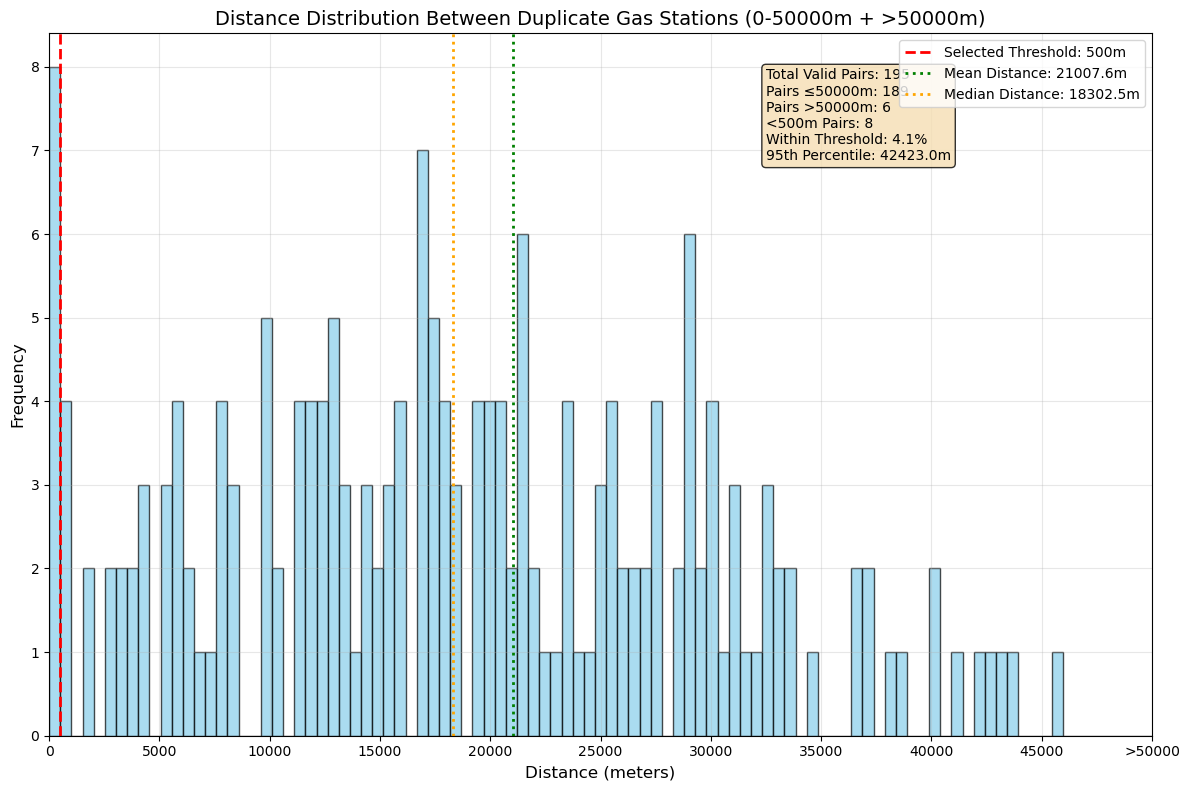

=== Distance Distribution Statistics ===
Total Valid Pairs: 195
Mean Distance: 21007.60m
Median Distance: 18302.46m
Standard Deviation: 19065.52m
Min Distance: 121.82m
Max Distance: 193754.70m
25th Percentile: 11151.75m
75th Percentile: 27551.76m
95th Percentile: 42423.00m
99th Percentile: 96532.33m
Pairs within 500m threshold: 8
Percentage within threshold: 4.10%


In [14]:
# Example
tmp_year = 2017
print(f"Analyzing distance distribution for duplicate gas stations in GS {tmp_year}...")
duplicates_idx, distances = find_duplicates_with_distance(
    GS_data_set[tmp_year], match_columns, distance_threshold=500, plot_distribution=True, non_null_cols=['address'], show_missing = True,max_display_distance=50000
)

In [ ]:
# Find Duplicate Charging stations
tmp_year = 2019
print(f"Analyzing distance distribution for duplicate charging stations in CS {tmp_year}...")
duplicates_idx, distances = find_duplicates_with_distance(
    CS_data_set[tmp_year], match_columns, distance_threshold=500, plot_distribution=True, non_null_cols=['address'], max_display_distance=500
)

In [15]:
duplicate_inspection_data = extract_duplicates_for_inspection(
    GS_data_set[tmp_year], duplicates_idx, match_columns, distance_threshold=50000
)

if len(duplicate_inspection_data) > 0:
    print(f"\n=== 按组显示重复数据 ===")
    for group_id in sorted(duplicate_inspection_data['group_id'].unique())[:20]:  # 只显示前20组
        group_data = duplicate_inspection_data[duplicate_inspection_data['group_id'] == group_id]
        print(f"\n--- 第 {group_id} 组 (共 {len(group_data)} 个加油站) ---")
        print(group_data.to_string(index=True))

发现 163 个重复的加油站，分为 62 组
每组内的加油站距离都在 50000米以内

=== 按组显示重复数据 ===

--- 第 0 组 (共 2 个加油站) ---
      group_id pname cityname adname address name     wgs84_x    wgs84_y  distance_to_nearest_duplicate
2777         0   云南省      昆明市    晋宁区      []  加油站  102.490535  24.687901                     121.824993
2778         0   云南省      昆明市    晋宁区      []  加油站  102.490248  24.688965                     121.824993

--- 第 1 组 (共 2 个加油站) ---
      group_id   pname cityname adname address            name     wgs84_x    wgs84_y  distance_to_nearest_duplicate
8576         1  内蒙古自治区    乌兰察布市    卓资县      []  土堡子服务区-中国石油加油站  112.314788  41.039067                     564.260439
8577         1  内蒙古自治区    乌兰察布市    卓资县      []  土堡子服务区-中国石油加油站  112.310920  41.043219                     564.260439

--- 第 2 组 (共 2 个加油站) ---
      group_id   pname cityname adname address name     wgs84_x    wgs84_y  distance_to_nearest_duplicate
6669         2  内蒙古自治区      乌海市    海南区      []  加油站  106.905950  39.098234                 

C:\Users\31155\AppData\Local\Temp\ipykernel_44812\2713741883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_duplicates['distance_to_nearest_duplicate'] = 0.0


In [12]:
GS_data_set[tmp_year].loc[duplicates_idx]

,name,address,wgs84_x,wgs84_y,tel,pname,cityname,adname,大类,中类,小类,timestamp,pname_EN,cityname_EN,corporation
497,中国石化颛桥服务区加油站,颛桥镇颛桥服务区,121.408979,31.067503,,上海市,上海市,闵行区,汽车服务,加油站,中国石化,20171109194909.446802+08:00,Shanghai,Shanghai,CPCC
498,中国石化颛桥服务区加油站,颛桥镇颛桥服务区,121.411170,31.067208,021-64894911,上海市,上海市,闵行区,汽车服务,加油站,中国石化,20171109194909.4472898+08:00,Shanghai,Shanghai,CPCC
106,中国石化练塘服务区加油站,S32申湖高速练塘服务区,121.078464,30.965025,,上海市,上海市,青浦区,汽车服务,加油站,中国石化,20171109194818.3901345+08:00,Shanghai,Shanghai,CPCC
107,中国石化练塘服务区加油站,S32申湖高速练塘服务区,121.079884,30.965572,,上海市,上海市,青浦区,汽车服务,加油站,中国石化,20171109194818.3907896+08:00,Shanghai,Shanghai,CPCC
84,中国石化淀山湖服务区沪青平加油站,西岑镇沪渝高速淀山湖服务区,120.936285,31.062859,021-59294074,上海市,上海市,青浦区,汽车服务,加油站,中国石化,20171109194816.5279238+08:00,Shanghai,Shanghai,CPCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117217,中国石油曹集屯服务区加油站,G1211吉黑高速附近,127.409220,49.878850,,黑龙江省,黑河市,爱辉区,汽车服务,加油站,中国石油,20171109194600.0283324+08:00,Heilongjiang Province,Heihe City,CNPC
116005,中国石油老莱服务区加油站,"老莱镇嫩泰高速老莱服务区,路东侧",124.983734,48.657251,,黑龙江省,齐齐哈尔市,讷河市,汽车服务,加油站,中国石油,20171109194545.3380692+08:00,Heilongjiang Province,Qiqihar City,CNPC
116006,中国石油老莱服务区加油站,"老莱镇嫩泰高速老莱服务区,路东侧",124.985372,48.658652,,黑龙江省,齐齐哈尔市,讷河市,汽车服务,加油站,中国石油,20171109194545.3385544+08:00,Heilongjiang Province,Qiqihar City,CNPC
115522,加油站,044县道南50米,123.048548,47.071210,,黑龙江省,齐齐哈尔市,龙江县,汽车服务,加油站,加油站,20171109194531.5525484+08:00,Heilongjiang Province,Qiqihar City,Other


In [13]:
calculate_distance_with_xy(121.40897940493528,31.06750331853592,121.41116989621544,31.067207695004573)

211.2076485924567

In [ ]:
GS_data_set[2019][GS_data_set[2019]['address'] == '[]']

In [ ]:
import time
print("==============GS with Distance Filter==============")
for year in GS_data_set.keys():
    data_tmp = GS_data_set[year]
    
    # Original duplicates (column-based only)
    original_duplicates = data_tmp[data_tmp.duplicated(subset=match_columns, keep=False)]
    original_rate = len(original_duplicates) / len(data_tmp) * 100
    
    # Distance-filtered duplicates
    distance_duplicates_idx = find_duplicates_with_distance(data_tmp, match_columns, 50, plot_distribution=False)
    distance_rate = len(distance_duplicates_idx) / len(data_tmp) * 100
    
    print(f"Year {year}: Original: {original_rate:.2f}%, With 50m filter: {distance_rate:.2f}%")
    time.sleep(0.1)  # To avoid overwhelming output

In [ ]:
print("==============CS with Distance Filter==============")
for year in CS_data_set.keys():
    data_tmp = CS_data_set[year]
    
    # Original duplicates (column-based only)
    original_duplicates = data_tmp[data_tmp.duplicated(subset=match_columns, keep=False)]
    original_rate = len(original_duplicates) / len(data_tmp) * 100
    
    # Distance-filtered duplicates
    distance_duplicates_idx = find_duplicates_with_distance(data_tmp, match_columns, 50, plot_distribution=False)
    distance_rate = len(distance_duplicates_idx) / len(data_tmp) * 100
    
    print(f"Year {year}: Original: {original_rate:.2f}%, With 50m filter: {distance_rate:.2f}%")
    time.sleep(0.5)

In [ ]:
sh_2013_gs_data = GS_data_set[2013][GS_data_set[2013]['pname'] == '上海市']
sh_2013_gs_data

In [ ]:
sh_2014_gs_data = GS_data_set[2014][GS_data_set[2014]['pname'] == '上海市']
sh_2014_gs_data

In [ ]:
# Analyze coordinate differences between same gas stations in Shanghai 2013 vs 2014
import numpy as np
import matplotlib.pyplot as plt

# Merge data to find matching stations
merged_data = pd.merge(
    sh_2013_gs_data, sh_2014_gs_data, 
    on=match_columns, 
    suffixes=('_2013', '_2014')
)

print(f"Matched stations between 2013 and 2014: {len(merged_data)}")

if len(merged_data) > 0:
    # Calculate coordinate differences
    merged_data['x_diff'] = merged_data['wgs84_x_2014'] - merged_data['wgs84_x_2013']
    merged_data['y_diff'] = merged_data['wgs84_y_2014'] - merged_data['wgs84_y_2013']
    
    # Calculate distance differences in meters
    merged_data['distance_diff'] = merged_data.apply(
        lambda row: calculate_distance_with_xy(
            row['wgs84_x_2013'], row['wgs84_y_2013'],
            row['wgs84_x_2014'], row['wgs84_y_2014']
        ), axis=1
    )
    
    # Statistical analysis
    print("=== Coordinate Difference Statistics ===")
    print(f"X difference - Mean: {merged_data['x_diff'].mean():.6f}, Std: {merged_data['x_diff'].std():.6f}")
    print(f"Y difference - Mean: {merged_data['y_diff'].mean():.6f}, Std: {merged_data['y_diff'].std():.6f}")
    print(f"Distance difference (m) - Mean: {merged_data['distance_diff'].mean():.2f}, Std: {merged_data['distance_diff'].std():.2f}")
    print(f"Max distance difference: {merged_data['distance_diff'].max():.2f}m")
    print(f"Stations with >50m difference: {(merged_data['distance_diff'] > 50).sum()}")
    
    # Distribution analysis with box plots
    plt.figure(figsize=(15, 10))
    
    # Histograms
    plt.subplot(2, 3, 1)
    plt.hist(merged_data['x_diff'], bins=30, alpha=0.7, color='blue')
    plt.title('X Coordinate Differences (Histogram)')
    plt.xlabel('Longitude Difference')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 2)
    plt.hist(merged_data['y_diff'], bins=30, alpha=0.7, color='green')
    plt.title('Y Coordinate Differences (Histogram)')
    plt.xlabel('Latitude Difference')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 3)
    plt.hist(merged_data['distance_diff'], bins=30, alpha=0.7, color='red')
    plt.title('Distance Differences (Histogram)')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Frequency')
    
    # Box plots to show distribution and outliers
    plt.subplot(2, 3, 4)
    plt.boxplot(merged_data['x_diff'], vert=True)
    plt.title('X Coordinate Differences (Box Plot)')
    plt.ylabel('Longitude Difference')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 5)
    plt.boxplot(merged_data['y_diff'], vert=True)
    plt.title('Y Coordinate Differences (Box Plot)')
    plt.ylabel('Latitude Difference')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 6)
    plt.boxplot(merged_data['distance_diff'], vert=True)
    plt.title('Distance Differences (Box Plot)')
    plt.ylabel('Distance (meters)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print quantile information for better understanding of distribution
    print("\n=== Distribution Quantiles ===")
    print("X Differences:")
    print(f"  Q1 (25%): {merged_data['x_diff'].quantile(0.25):.6f}")
    print(f"  Median (50%): {merged_data['x_diff'].quantile(0.5):.6f}")
    print(f"  Q3 (75%): {merged_data['x_diff'].quantile(0.75):.6f}")
    print(f"  IQR: {merged_data['x_diff'].quantile(0.75) - merged_data['x_diff'].quantile(0.25):.6f}")
    
    print("\nY Differences:")
    print(f"  Q1 (25%): {merged_data['y_diff'].quantile(0.25):.6f}")
    print(f"  Median (50%): {merged_data['y_diff'].quantile(0.5):.6f}")
    print(f"  Q3 (75%): {merged_data['y_diff'].quantile(0.75):.6f}")
    print(f"  IQR: {merged_data['y_diff'].quantile(0.75) - merged_data['y_diff'].quantile(0.25):.6f}")
    
    print("\nDistance Differences (meters):")
    print(f"  Q1 (25%): {merged_data['distance_diff'].quantile(0.25):.2f}")
    print(f"  Median (50%): {merged_data['distance_diff'].quantile(0.5):.2f}")
    print(f"  Q3 (75%): {merged_data['distance_diff'].quantile(0.75):.2f}")
    print(f"  95th percentile: {merged_data['distance_diff'].quantile(0.95):.2f}")
    print(f"  99th percentile: {merged_data['distance_diff'].quantile(0.99):.2f}")
    print(f"  IQR: {merged_data['distance_diff'].quantile(0.75) - merged_data['distance_diff'].quantile(0.25):.2f}")
    
    # Show stations with large coordinate differences
    large_diff = merged_data[merged_data['distance_diff'] > 50]
    if len(large_diff) > 0:
        print(f"\nStations with >50m coordinate difference:")
        print(large_diff[['name', 'address', 'distance_diff']].head())
else:
    print("No matching stations found between 2013 and 2014")